比賽：Store Sales - Time Series Forecasting

比賽說明：使用時間序列來預測厄瓜多大型雜貨零售商Corporación Favorita的商店銷售數據，預測在不同Favorita商店出售的數千種商品（id）的銷售量（sales）。test.csv 中的日期為訓練數據中最後日期之後的 15 天。

選擇動機：我是一名就讀管理學院的學生，一開始在「getting started」（入門）中發現了這個比賽，深感興趣。雖然我知道要參加這個比賽還需要上前導課程，但我仍然選擇了這個比賽。現在，許多公司都使用機器學習來預測未來產品的銷售量走勢，例如每年舉行的年度檢討會上，公司必須提出對於明年景氣的展望和公司的發展預測。因此，在確保另一個Titanic比賽可以完成下，我仍花時間去了解所謂的時間序列，參加這個比賽將使我更深入了解機器學習在商業上的應用，提高我的技能和知識水平。

training data欄位說明：
id：產品號碼
date：日期
store_nbr：識別銷售產品的商店
family：識別銷售的產品類型（如汽車、雞蛋、書本）
sales：給出在特定日期的某個商店內某個產品類型的總銷售額。由於產品可以以分數單位銷售（例如 1.5 公斤的奶酪，而不是 1 袋薯片），因此可能存在分數。
onpromotion：給出在特定日期的某個商店中促銷的某個產品類型的總數量。


在oil.csv檔中，顯示每日的油價，包括訓練和測試數據時間段內的值。（厄瓜多爾是一個依賴石油的國家，其經濟健康狀況極易受到油價震盪的影響。）


在holidays_events.csv 檔案中要特別注意 transferred 欄位，它表示一個假日在日曆上是該日期，但是政府已經將其轉移到另一個日期慶祝。如果要找到實際慶祝的日期，需要尋找 type 為 Transfer 的相應列。例如，Independencia de Guayaquil 假日從 2012-10-09 轉移到了 2012-10-12，這意味著它真正是在 2012-10-12 慶祝的。類型為 Bridge 的日期是額外添加到假期中的日期（例如，為了延長週末假期，像台灣補假），這些通常由類型為 Work Day 的日期補回，該日期通常不工作（例如，星期六，像補班補課日），用於補償 Bridge 假期。此外，還有一些額外的假日是在常規的日曆假期上添加的，例如在聖誕節前後（聖誕前夕成為假日）。

特別注意：
薪水每兩周支付一次，分別是在每月的15日和最後一天，可能會影響超市的銷售情況（如人們在發薪日買得比較多）。另外，2016年4月16日，厄瓜多爾發生了7.8級地震。人們發起了救援行動，捐贈了水和其他急需品，這也可能會影響超市的銷售情況。

導入模組

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

設定圖形默認參數

In [18]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

定義csv檔中不同欄位的資料類型，以便在導入資料時進行轉換。例如，'store_nbr' 和 'family' 欄位被定義為類別型，因為它們只有有限的可能值；'sales' 欄位被定義為浮點型，因為它代表了商品的銷售量，可能會有小數部分（如1.5公斤奶酪）；'onpromotion' 欄位被定義為無號整數型別，因為它只會取 0 或 1 的值，且該欄位的預設值為 0。

In [19]:
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

load data，並將'date'欄位轉換為日的週期性索引

In [20]:
store_sales = pd.read_csv("data/train.csv",
                          dtype=dtype,
                          parse_dates=['date'],
                          infer_datetime_format=True,
                          ).set_index('date').to_period('D')

設定多層索引，以便分析銷售資料

In [21]:
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)

計算每日平均銷售額，使用課堂上學的groupby（）將store_sales依照date這個欄位做分組，再對sales欄位做平均。

In [22]:
average_sales = store_sales.groupby('date').mean()['sales']

In [23]:
df = pd.DataFrame({'date': average_sales.index, 'average_sales': average_sales.values})

對average_sales的DataFrame"df"進行資料處理，將df的date欄位轉換為datetime格式，並將其設為index。

In [24]:
df['date'] = df['date'].dt.to_timestamp()
df.set_index('date', inplace=True)

新增一個欄位time，並用np.arange()函數產生一個等差數列，用以表示時間序列的time step

In [25]:
df['time'] = np.arange(len(df.index))

將 X 設為 df 中的 time 欄位。（特徵資料）
將 y 設為 df 中的 average_sales 欄位。（目標資料）

In [26]:
X = df.loc[:, ['time']]
y = df.loc[:, 'average_sales']

In [27]:
model = LinearRegression()

使用fit()訓練模型

In [28]:
model.fit(X, y)

LinearRegression()

In [29]:
y_pred = pd.Series(model.predict(X), index=X.index)

將真實值y和預測值y_pred繪製在同一張圖中，使用了plot()和進行參數設置，例如alpha參數設置透明度，linewidth設置線條寬度等。

Text(0.5, 1.0, 'Time Plot of Total Store Sales')

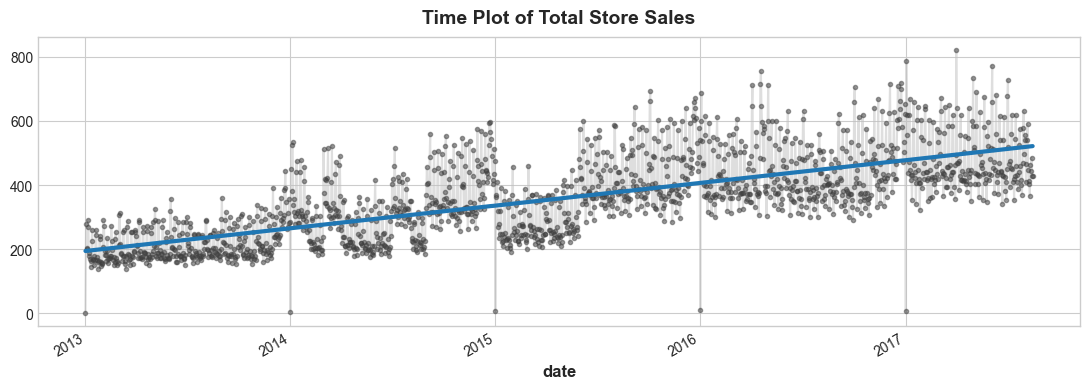

In [30]:
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales')

建立lag feature，使用shift()，建立一個名為lag_1的新欄位，也就是前一天的銷售額。

In [31]:
df = average_sales.to_frame()

lag_1 = df['sales'].shift(1)

df['lag_1'] = lag_1

選擇lag_1作為特徵（loc）

In [32]:
X = df.loc[:, ['lag_1']]

dropna()用於去除 lag_1 中的NaN（缺失值是因為第一天沒有前一天的銷售額而產生的），

In [33]:
X.dropna(inplace=True)

使用 align() 方法將特徵和目標變量對齊以消除索引上的任何不一致性。

In [34]:
y = df.loc[:, 'sales']
y, X = y.align(X, join='inner')

In [35]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [36]:
y_pred = pd.Series(model.predict(X), index=X.index)

繪製 Average Sales 的 Lag Plot

[None,
 Text(0, 0.5, 'sales'),
 Text(0.5, 0, 'lag_1'),
 Text(0.5, 1.0, 'Lag Plot of Average Sales')]

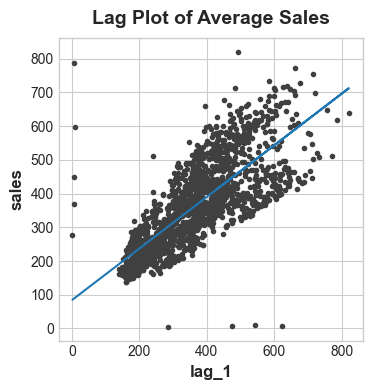

In [37]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales')

製作移動平均線圖，使用了滾動平均法（rolling）來計算平均銷售額，其中window參數指定了計算滾動平均所用的時間窗口大小，center=True表示平均值的時間點位於窗口中心，min_periods參數表示至少有多少個非NA數據才進行平均計算。

In [38]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

繪製了原始的銷售額和rolling後的數據。alpha參數表示散步圖的透明度，linewidth參數表示折線圖的線寬度。最後將繪製的圖表儲存至變數ax中。

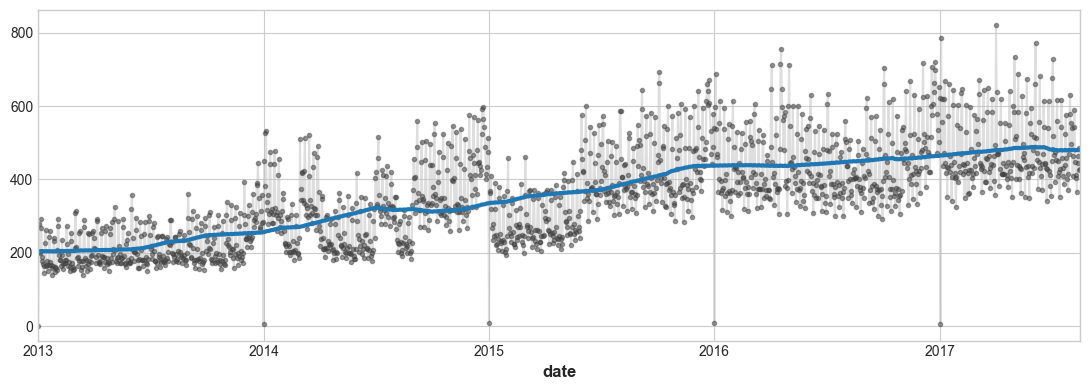

In [39]:
ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

為時間序列加上趨勢（trend），將原始資料 average_sales 複製到變數 y 中

In [40]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy()

透過DeterministicProcess模組生成一個order=3的多項式，用來描述趨勢的形狀，包括線性、二次、三次等。

In [41]:
dp = DeterministicProcess(index=y.index, order=3)

這個多項式通過in_sample()得到內部樣本（即過去的時間序列資料），應用到原始資料的時間索引上，得到趨勢特徵的值，保存在變數 X 中。同時，通過out_of_sample()，也可以生成未來一段時間的趨勢特徵值，這裡是預測未來90天的趨勢特徵，保存在變數 X_fore 中。此處與時間序列課程step2相似。

In [42]:
X = dp.in_sample()
X_fore = dp.out_of_sample(steps=90)

建立90天的預測

In [43]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [44]:
y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

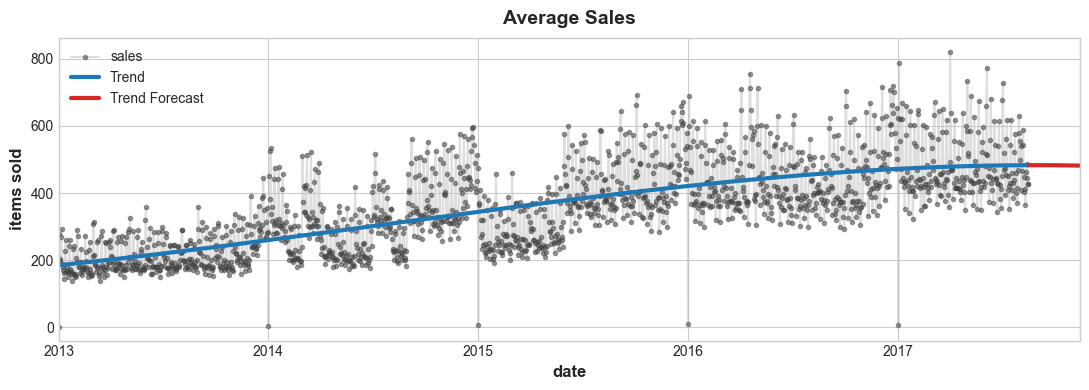

In [45]:
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend()

由上圖可得知，線性回歸模型的趨勢幾乎與移動平均圖相同。

高階多項式不適合預測，11階多項式將包含t ** 11等項，此類項往往會在訓練期之外迅速發散，從而使預測非常不可靠。由下方試驗可證。

In [46]:
dp = DeterministicProcess(index=y.index, order=11)
X = dp.in_sample()

In [47]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [48]:
y_pred = pd.Series(model.predict(X), index=X.index)

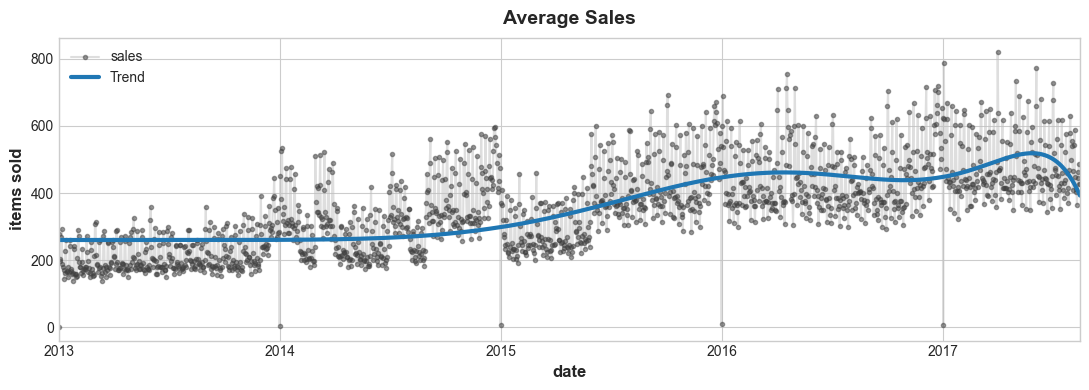

In [49]:
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax.legend()

用11階多項式預測90天的趨勢

In [50]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

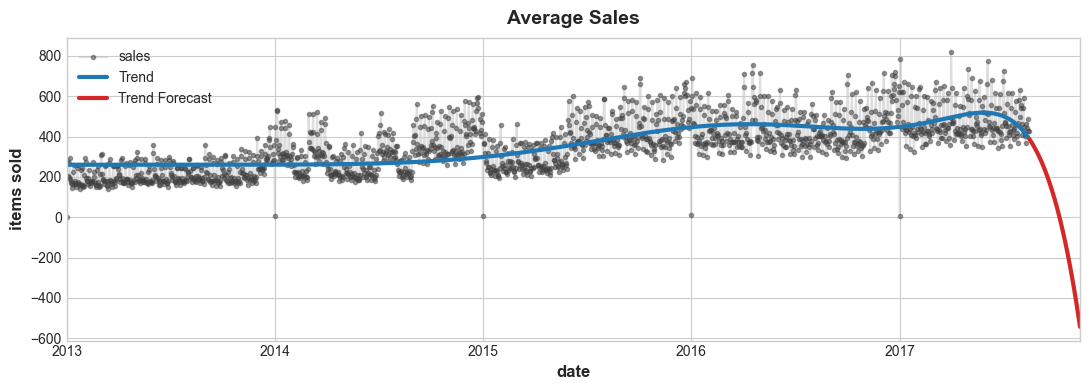

In [51]:
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

繪製季節性圖和周期圖，定義seasonal_plot()和plot_periodogram()

In [52]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [53]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

detrend（去趨勢）的目的是將時間序列中的長期趨勢或季節性等作用從序列中刪除。去趨勢通常用於分析時間序列的短期變化。

In [54]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

load holiday資料，建立季節性特徵，以觀察holiday對sales的影響。

In [55]:
holidays_events = pd.read_csv("data/holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

In [56]:
holidays_events = holidays_events.set_index('date').to_period('D')

In [57]:
store_sales = pd.read_csv("data/train.csv",
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

使用 groupby 按日期對數據進行分組，然後計算每一組的平均值。接下來，使用squeeze將結果從DataFrame轉換為Series。最後，使用 loc從Series中選出'2017'年的數據作為特徵。此時的 average_sales 是一個 Series，其索引是日期，值是每日的平均銷售額。

In [58]:
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

加上兩個欄位：week 和 day，分別表示該日期屬於當年的第幾週和星期幾。繪製季節性圖，觀察銷售量的季節性，其中period參數設定為 'week'，表示要觀察每週的季節性，freq 參數設定為 'day'，表示要用星期幾來區分不同的週期。

C:\Users\maruk\AppData\Local\Temp\ipykernel_300\1565446183.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(
C:\Users\maruk\AppData\Local\Temp\ipykernel_300\283182587.py:6: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  plot_periodogram(average_sales);


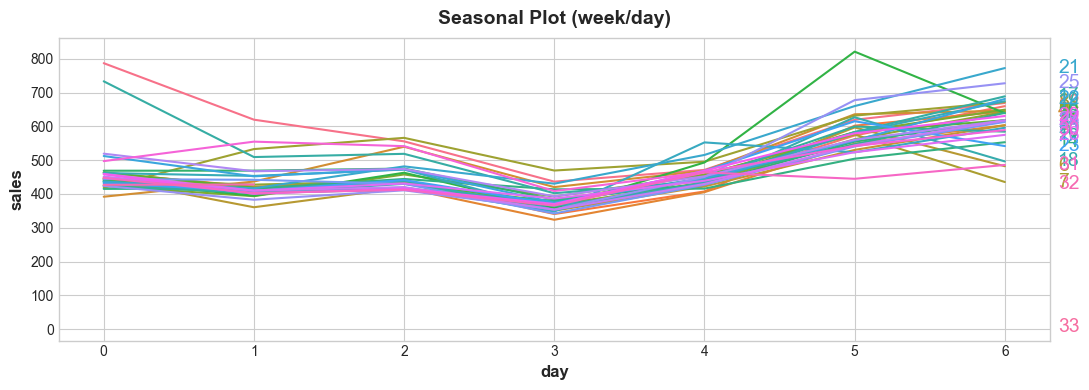

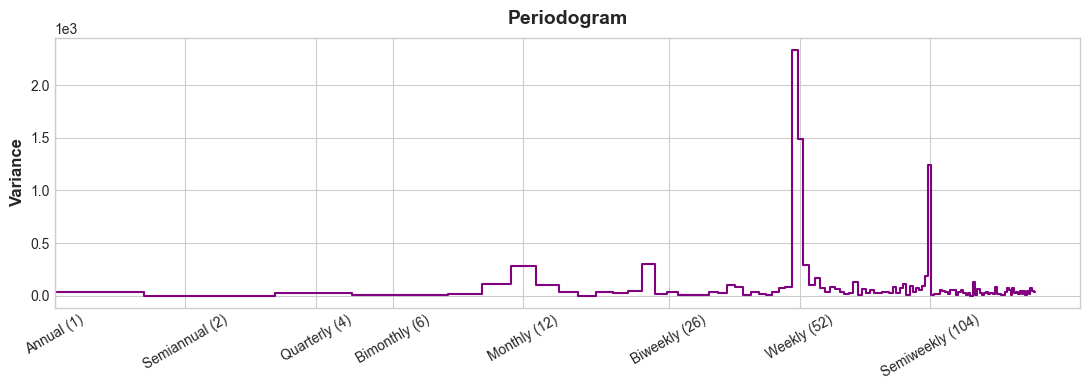

In [59]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

plot_periodogram(average_sales);

由季節性圖和周期圖可看出每周季節性較強

使用 DeterministicProcess 創建季節性特徵

In [60]:
y = average_sales.copy()

drop=true代表避免多重共線性

In [61]:
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

In [62]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

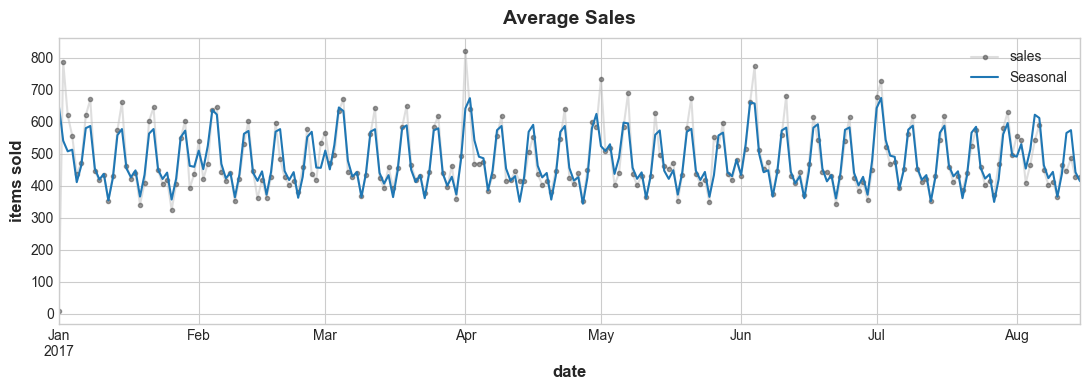

In [63]:
y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

由上圖可看出銷售量有季節性變化特徵

y_deseason是原始資料y與進行季節性預測後的殘差，其中y_pred是前面所述的季節性預測值。

In [64]:
y_deseason = y - y_pred

使用sharex=True和sharey=True設置了共享坐標軸，使兩個圖表在水平和垂直方向上都具有相同的刻度單位。

C:\Users\maruk\AppData\Local\Temp\ipykernel_300\711158458.py:2: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  ax1 = plot_periodogram(y, ax=ax1)
C:\Users\maruk\AppData\Local\Temp\ipykernel_300\711158458.py:4: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  ax2 = plot_periodogram(y_deseason, ax=ax2);


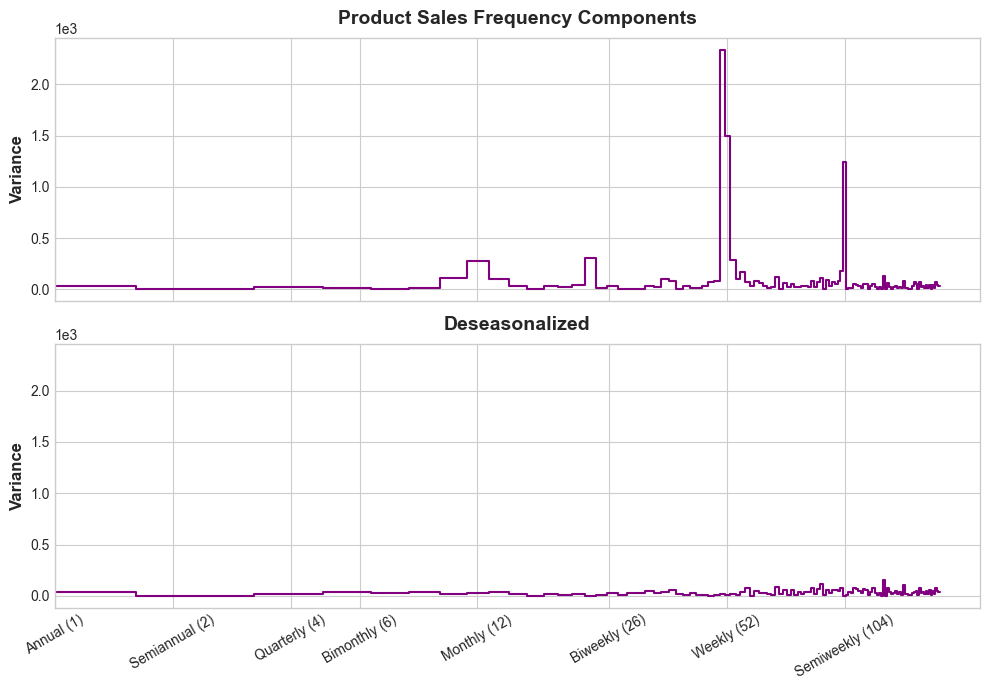

In [65]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

在holidays資料中的locale包含national、local、regional三種類別，選擇"locale"列包含"National"或"Regional"字串的行，並將日期索引設置為PeriodIndex。然後使用.loc方法篩選2017年至8月15日的節日data，並僅選擇“description”列。接著使用.cat.remove_unused_categories()刪除未使用的節日描述，意思是刪除原始資料中存在的但是在當前資料中沒有出現過的分類。

In [66]:
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

繪製去季節化的銷售額

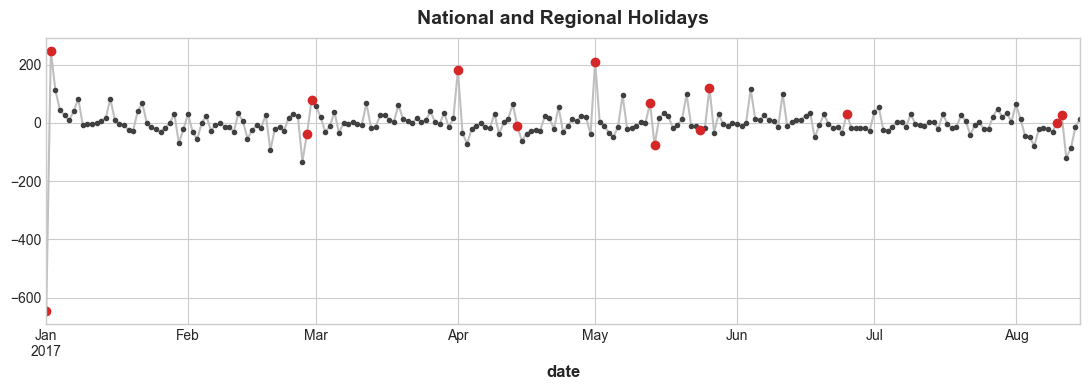

In [67]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

建立holidays特徵，使用上課所教授的get_dummies將假期資料轉換為0和1組成的數據。

In [68]:
X_holidays = pd.get_dummies(holidays)

使用join()將建立好的X_holidays與訓練資料X中日期相同的數據合併在一起。由於某些日期可能不是假期，可能會出現NaN，用0.0來填補。使用上課所教的fillna。

In [69]:
X2 = X.join(X_holidays, on='date').fillna(0.0)

使用LinearRegression()進行線性回歸模型的訓練，得到預測值 y_pred。

In [70]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

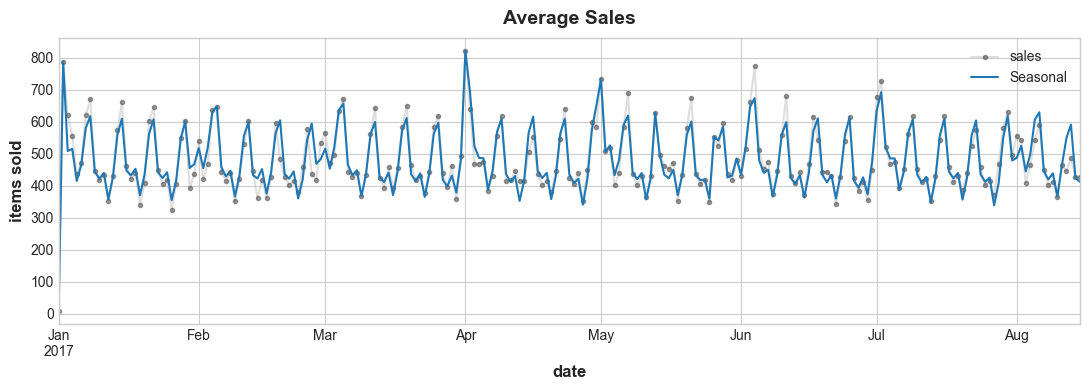

In [71]:
y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

將原本以store_nby、family為索引的多層次DataFrame改為一層多層次DataFrame，並loc取出2017年的所有資料。

In [72]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

建立training data：
建立了一個CalendarFourier，表示一個由正弦和餘弦函數構成的傅里葉特徵，用於描述資料的季節性變化。freq='M'表示資料的時間間隔為月份，order=4表示在傅里葉特徵中使用4個正弦和余弦函數。dp由index和其他參數組成，constant=True表示包含一個截距，order=1 表示包含一階，seasonal=True表示包含季節性項。additional_terms=[fourier]表示包含前面創建的傅里葉特徵。最後，增加了一個名為 NewYear的特徵，為True表示資料的時間為新年的第一天，否則為 False。

In [73]:
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

In [74]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

將變數STORE_NBR設為'1'，將變數FAMILY設為'PRODUCE'，表示希望分析商店編號為1、產品類別為PRODUCE的銷售數據。

In [75]:
STORE_NBR = '1' 
FAMILY = 'PRODUCE'

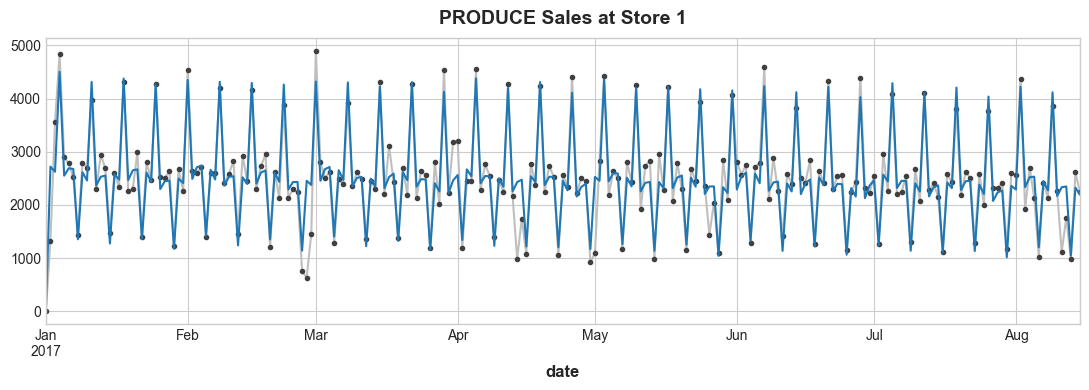

In [76]:
ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

因為時間緊急！先提交！！！

In [77]:
df_test = pd.read_csv("data/test.csv",
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

test.csv中的日期為訓練數據中最後日期之後的 15 天，所以設step=16，表示未來的日期，即從y的末尾開始往後16個時間步長。接下來，增加一個名為'NewYear'的特徵，這個特徵的值為True當該日期是新年（即1月1日）時，否則為False。

In [78]:
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)

使用stack將y_submit中store_nbr和 family堆疊在一起，然後使用join將id列合併進來。最後，將y_submit的列順序設置為 ['id', 'sales']

In [79]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])

In [80]:
y_submit.to_csv('submission.csv', index=False)

比賽結果：0.51090

由於時間加上程式往下還有三百多行...先停在這邊做總結

課堂連結：皆涉及對資料進行處理，如填補缺失值、使用regression進行建模與預測，而在觀察store sales時，也需要搭配周期圖等進行分析。在輸出模型時，都要將訓練模型放到test中，並挑選符合預測的時間範圍，也就是submission必須與test檔中的欄數相同。另外，也會使用到groupby、fillna、getdummies的方法。

延伸學習：
1.時間序列課程：在預測銷售額的過程中，我需要比對歷史資料進行趨勢分析，這是因為銷售額往往會受到季節性、週期性、趨勢性等因素的影響，了解這些因素有助於更準確地預測未來銷售額。因此，在這個比賽中一定要使用時間序列進行分析。在這次的學習過程中，我花了額外的時間去學習時間序列的用法，並學會了如何使用它進行趨勢分析和預測。在學習的過程中，我需要一直查詢程式的用法以及含意，雖然有些新知識需要弄懂，但我依然熱衷於學習新東西。
隨著越來越深入的學習，我發現了很多新的機器學習模型，例如隨機森林等，雖然無法再花時間去了解它，但我知道這些模型可以幫助我們更好地進行預測和分析。另外，由於每天都需要花時間上一下時間序列課程，所以每天都會接觸、觀察圖表，查看序列趨勢，我對圖表的熟悉程度也不斷提高。在課堂上，我們曾經使用sns.plot去觀察Survived與其他欄位的關聯性，但現在，我需要不斷畫趨勢線去找sales與其他欄位的關聯性，這樣才能更好地進行預測和分析。在這個過程中，只有不斷學習，才能不斷進步，去做更多事。

2.導入新模組：課程中也導入了新的模組如statsmodels和XGboost，讓我認識它們在機器學習上的應用。

3.程式碼重複：由於程式碼太長了，每當換一個步驟，我就必須重新讀取資料或設定圖表預設值。我深怕之前的更改會導致下一步無法使用，因為我無法記住所有修改過的程式碼。因此，我經常重複讀取資料以確保程式運行正常，導致出現大量重複的程式碼。為了避免這種情況，我應該要確定自己已經導入了什麼模組，讀取了什麼資料集，以及定義了哪些參數，以減少程式碼的重複並提高效率。但做完了我才去查可以使用一個叫版本控制工具（例如Git），可以更輕鬆地跟蹤和管理程式碼的更改，以減少錯誤和重複工作。

4.執行畫圖：畫圖必須將繪圖程式碼整段框起來在繪製圖表時，並使用Shift Enter來執行該儲存格，這樣可以確保代碼在執行時不會因為分段而出現錯誤，並且可以輕鬆地查看和比較不同繪圖的結果。

5.時間序列課程範例：在課程中，每堂課都會提供一個實際的範例來做該堂課的內容。我會跟著做並了解範例程式碼的意義，而不僅僅是複製貼上。我做了三個檔案，包括tunnel traffic、flu trends、Us retail sales，並在我的PDF檔中加上了註記。通過這些範例，我學會了如何運用更多的程式語言。此外，從課程範例中我發現，想要更加深入地了解時間序列的應用和相關技術，應該還可以研究更多的實際案例和練習，如股票市場預測、氣象預報、流感監測、交通流量預測等等，還能學到更多技巧和方法，以提升程式能力。

可以如何改善比賽結果？
1.增加時間：由於期中考週的緣故，我沒能在限定時間內完成後面數百行的說明。雖然我不能確定這會對提高準確率有沒有幫助，但我認為時間的增加可以帶來更好的結果。因為後面使用了混合模型，並開始進行機器學習的分析。

2.整理更多相關歷史資料：模型的訓練資料越多，模型學習到的趨勢就越準確。因此，蒐集更多與銷售額相關的歷史資料，可以提高模型的準確率。

3.調整資料：我認為因為機器學習是使用既有資料去進行預測，資料的品質對於模型的準確率影響應該很大，因此，必須花時間清洗和處理資料，例如刪除重複的資料、填補NaN等等，以提高資料的品質。

4.選擇合適的模型：根據資料的特性和需求，選擇適合的模型，例如線性迴歸、隨機森林等等。

5.調整模型參數：對於某些模型，可以透過調整其參數以達到更好的預測效果。例如，我在搜尋一些程式語言時，意外看到其他模型的應用，簡單地看了介紹，像在隨機森林中，可以藉由調整決策樹的數量、深度寬度、使用的特徵數等等達到更高的準確度。

6.集成學習：使用不同種模型預測，並進行整合，可以提高預測準確率，例如使用multioutput策略。

我發現還有時間！那就繼續打程式在下面！

從sklearn.metrics庫中引入均方根對數誤差（mean squared log error）函數。

從statsmodels.graphics.tsaplots庫中引入偏自相關圖（partial autocorrelation plot）函數。

In [81]:
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf

接下來進行很多重複動作...也是我在延伸學習講到的問題，再設一次圖形默認參數以及讀資料

In [82]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

使用lag feature進行預測，首先定義lagplot、plot_lags

In [83]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

In [84]:
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

load data

In [85]:
store_sales = pd.read_csv("data/train.csv",
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

In [86]:
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

選取family中的指定產品種類SCHOOL AND OFFICE SUPPLIES的銷售資料

In [87]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()

In [88]:
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

fit_intercept=False：不使用截距
model.fit(X_time, y)：使用模型對訓練資料進行擬合，其中X_time為自變數（時間），y為應變數（銷售額）。
y_deseason：計算出去除季節性影響後的銷售額，即原始銷售額減去迴歸模型預測值。
y_deseason.name = 'sales_deseasoned'：將去除季節性影響後的銷售額取名為sales_deseasoned。

In [89]:
model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

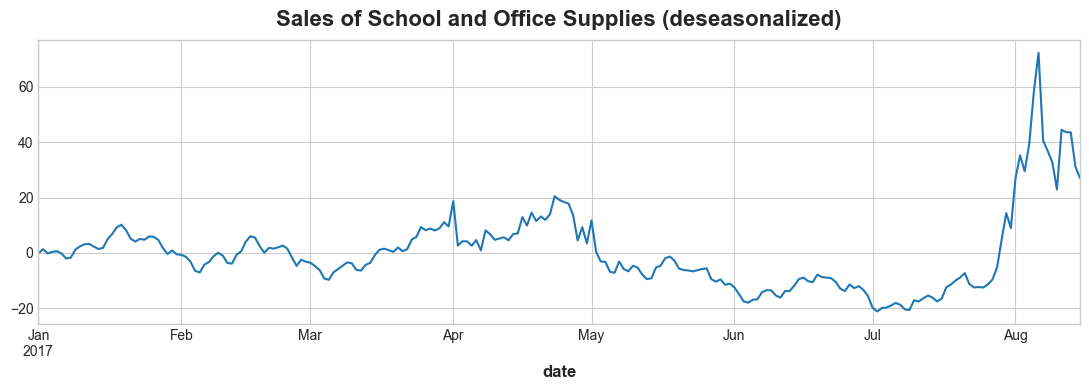

In [90]:
ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)");

畫周期圖，使用rolling()對原始y做七天的移動平均。

In [91]:
y_ma = y.rolling(7, center=True).mean()

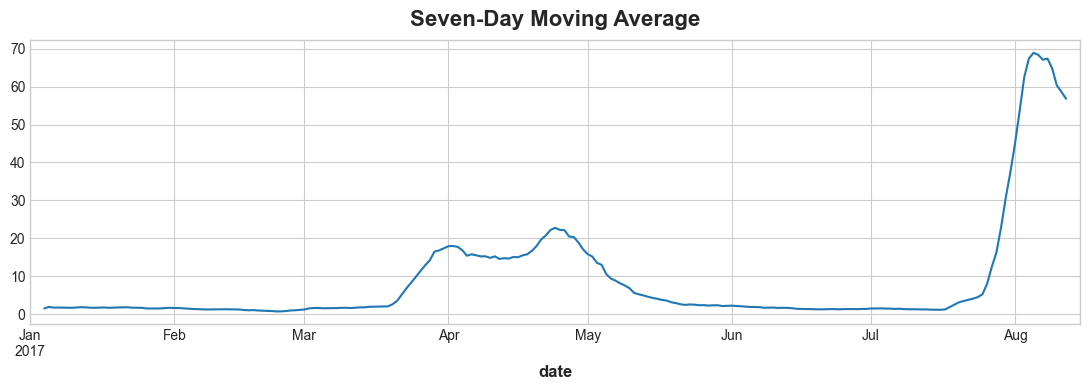

In [92]:
ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");

使用plot_pacf()畫出 y_deseason 的自相關圖，其中lags=8表示只畫出8個lag的自相關係數。自相關圖可以檢查時間序列資料中是否存在自相關，以及它們之間的相關性。如果有自相關存在，可能需要進一步處理時間序列資料以消除自相關。
最後，使用plot_lags()繪製y_deseason的前8個lag。nrows=2表示將圖分為2行，也就是每行畫4個滯後點。

c:\Users\maruk\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


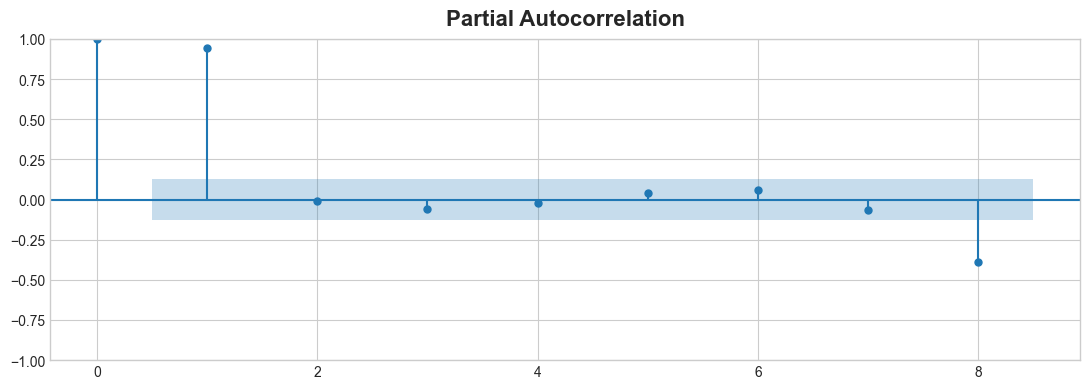

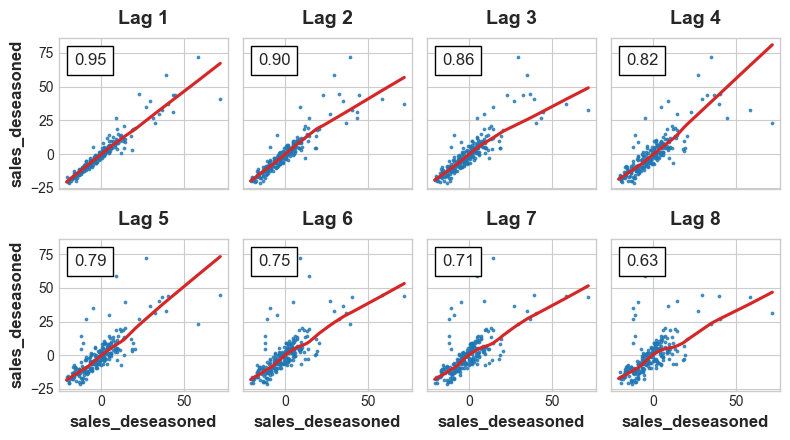

In [93]:
plot_pacf(y_deseason, lags=8);
plot_lags(y_deseason, lags=8, nrows=2);

從supply_sales中提取onpromotion欄位的值

In [94]:
onpromotion = supply_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

定義make_lags、make_leads

In [97]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)
X_lags = make_lags(y_deseason, lags=1)

In [98]:
def make_leads(ts, leads):
    return pd.concat(
        {
            f'y_lead_{i}': ts.shift(-i)
            for i in range(1, leads + 1)
        },
        axis=1)
X_promo = pd.concat([
    make_lags(onpromotion, lags=1),
    onpromotion,
    make_leads(onpromotion, leads=1),
], axis=1)

In [99]:
X = pd.concat([X_time, X_lags, X_promo], axis=1).dropna()
y, X = y.align(X, join='inner')

In [100]:
from sklearn.model_selection import train_test_split

test_size參數設定為30，表示test佔原始資料集的30%。shuffle 參數被設定為False，這表示我們不打算對資料進行隨機洗牌，並將預測結果限制在0.0到正無限大的範圍內。

In [101]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

In [102]:
model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

Root Mean Squared Log Error（RMSLE）是評估回歸模型預測準確度的指標，它是將預測值和實際值都取log後，計算MSE的平方根。

In [103]:
rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

Training RMSLE: 0.23974
Validation RMSLE: 0.34991


畫出預測school and office supplies產品的銷售預測圖

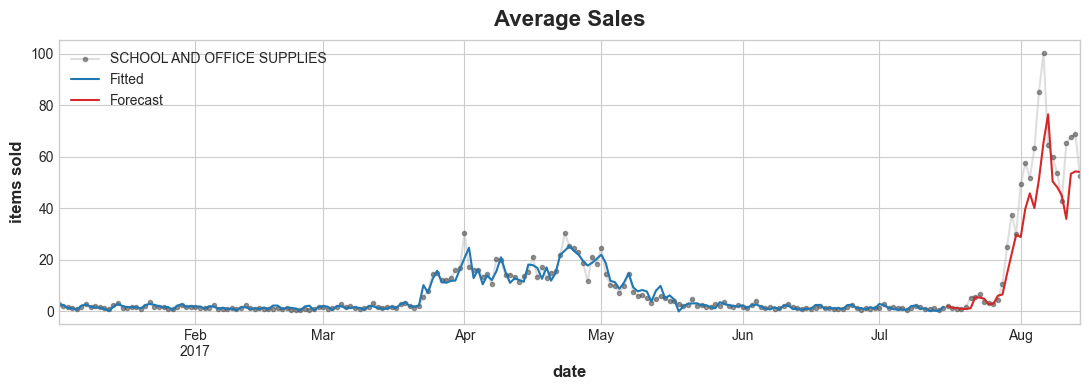

In [104]:
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

y_lag將銷售額的時間序列往後平移一個單位，得到了一個以前一天的銷售額作為當天銷售額的新欄位。

onpromo從supply_sales中選取'onpromotion'欄位，得到一個表示當天商品是否正在促銷的時間序列。

In [105]:
y_lag = supply_sales.loc[:, 'sales'].shift(1)
onpromo = supply_sales.loc[:, 'onpromotion']

mean_7計算銷售額的7天滾動平均值。

median_14計算銷售額的14天滾動中位數。

std_7計算銷售額的7天滾動標準差。

promo_7=計算商品是否正在促銷的7天滾動總和。

In [106]:
mean_7 = y_lag.rolling(7).mean()
median_14 = y_lag.rolling(14).median()
std_7 = y_lag.rolling(7).std()
promo_7 = onpromo.rolling(7, center=True).sum()

下面開始為用到XGBRegressor，但時間不足我說不完了...所以就先到這裡！